# Imports

In [11]:
import pymc as pm
import numpy as np
import pandas as pd
import causalpy as cp
import arviz as az
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# seleção de doadoras com inferencia bayesiana

In [ ]:
# # bloco muito pesado, não executar

# # Criando um modelo bayesiano para seleção de séries doadoras
# with pm.Model() as model:
#     # Priori para os pesos: assume que todos os pesos começam uniformemente distribuídos
#     # Dirichlet assegura que os pesos são positivos e somam 1
#     weights = pm.Dirichlet("weights", a=np.ones(donors.shape[1]))
    
#     # Combinação linear dos valores das séries doadoras usando os pesos
#     # Calcula o valor esperado da série tratada como uma soma ponderada das doadoras
#     expected = pm.math.dot(donors, weights)
    
#     # Priori para o desvio padrão do termo de erro (positiva e centrada em valores pequenos)
#     sigma = pm.HalfNormal("sigma", sigma=1)
    
#     # Verossimilhança: modela a série tratada como uma distribuição normal com média 'expected' e desvio padrão 'sigma'
#     y_obs = pm.Normal("y_obs", mu=expected, sigma=sigma, observed=treated)
    
#     # Amostragem: realiza a inferência bayesiana usando MCMC
#     # Gera 1000 amostras da distribuição posterior para os parâmetros
#     trace = pm.sample(1000, return_inferencedata=True, random_seed=42)

# # Analisar os pesos das séries doadoras
# # Calcula a média posterior dos pesos estimados para cada série doadora
# weights_post = trace.posterior["weights"].mean(dim=["chain", "draw"])
# # Converte os pesos em um DataFrame para facilitar a visualização
# weights_df = pd.DataFrame({"Series": df.columns[2:], "Weight": weights_post.values})
# print("Pesos Posteriores:")
# print(weights_df)  # Mostra os pesos estimados de cada série doadora

# # Selecionar séries doadoras com pesos significativos
# threshold = 0.1  # Define um limiar para considerar uma série como relevante
# selected_series = weights_df[weights_df["Weight"] > threshold]["Series"].tolist()  # Filtra séries com pesos > limiar
# print("\nSéries Selecionadas para Controle Sintético:", selected_series)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, sigma]


c:\Users\willi\codigos\pymc_venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 295 draw iterations (4_000 + 1_180 draws total) took 3922 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# dados simulados

In [2]:
# Exemplo de entrada
# O DataFrame deve conter:
# - Uma coluna com a série tratada, identificada pelo sufixo "_t"
# - Uma coluna `anomes` indicando os períodos
# - Todas as outras colunas são potenciais séries doadoras

# Criando um conjunto de dados fictício para simular o problema
data = {
    "anomes": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],  # Período de tempo
    "serie_t": [10, 12, 13, 15, 17, 18, 20, 21, 23, 25, 27, 28, 30, 31, 33, 34],  # Série tratada
    "a": [9, 11, 14, 16, 18, 19, 21, 23, 24, 26, 28, 29, 31, 33, 34, 36],  # Série doadora 1
    "b": [15, 16, 18, 20, 22, 23, 25, 27, 28, 30, 32, 33, 35, 36, 38, 39],  # Série doadora 2
    "c": [10, 12, 13, 15, 17, 18, 20, 21, 23, 24, 26, 27, 29, 30, 32, 33],  # Série doadora 3
    "d": [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],  # Série doadora 4
    "e": [8, 9, 10, 11, 13, 14, 16, 18, 19, 20, 22, 23, 25, 26, 28, 29],  # Série doadora 5
    "f": [12, 14, 16, 17, 19, 21, 22, 24, 25, 27, 29, 30, 32, 33, 35, 36],  # Série doadora 6
    "g": [11, 12, 14, 15, 16, 18, 19, 21, 22, 24, 26, 27, 29, 30, 32, 33],  # Série doadora 7
}
# Converte o dicionário em um DataFrame para manipulação mais fácil
df = pd.DataFrame(data)

# Seleção de doadoras com ridge par a par

In [4]:
# Índice que marca o início do tratamento
treatment_time = 9  # Período pré-tratamento: linhas 0 a 8

# Filtrar o período pré-tratamento
df_pre = df.iloc[:treatment_time]

# Identificar colunas de tratamento e doadoras
treated_col = [col for col in df_pre.columns if col.endswith("_t")][0]
donors_cols = [col for col in df_pre.columns if col not in [treated_col, "anomes"]]

# Separar dados da série tratada e possíveis doadoras no período pré-tratamento
y_pre = df_pre[treated_col].values  # Valores da série tratada no período pré-tratamento

# Avaliar doadoras individualmente (usando apenas o período pré-tratamento)
results = []
for donor in donors_cols:
    X_pre = df_pre[donor].values.reshape(-1, 1)  # Valores da série doadora no período pré-tratamento

    # Ajustar Ridge Regression para cada doadora individualmente
    ridge = Ridge(alpha=1.0)  # Penalização
    ridge.fit(X_pre, y_pre)

    # Predições no período pré-tratamento
    y_pred_pre = ridge.predict(X_pre)

    # Calcular métricas de ajuste
    mse = mean_squared_error(y_pre, y_pred_pre)  # Erro Quadrático Médio
    r2 = r2_score(y_pre, y_pred_pre)  # Coeficiente de Determinação R²
    coef = ridge.coef_[0]  # Coeficiente da série doadora

    # Salvar resultados
    results.append({"Doador": donor, "R2": r2, "MSE": mse, "Coeficiente": coef})

# Converter resultados em DataFrame
results_df = pd.DataFrame(results)

# Ordenar doadoras pelo R² ou outro critério
results_df = results_df.sort_values(by="R2", ascending=False)

# Selecionar as doadoras mais relevantes
top_n = 2  # Quantidade de doadoras a selecionar
selected_donors = results_df.head(top_n)["Doador"].tolist()

# Exibir resultados
print("Resultados da Regressão Individual (Pré-Tratamento):")
print(results_df)
print("\nDoadoras Selecionadas:")
print(selected_donors)

# Gerar DataFrame final com as doadoras selecionadas (completo, incluindo pós-tratamento)
df_selected = df[["anomes", treated_col] + selected_donors]

# Exibir DataFrame final
print("\nDataFrame Final para Controle Sintético:")
print(df_selected)



Resultados da Regressão Individual (Pré-Tratamento):
  Doador        R2       MSE  Coeficiente
2      c  0.999958  0.000711     0.993558
3      d  0.995698  0.073722     1.573770
1      b  0.991503  0.145607     0.931516
5      f  0.987751  0.209900     0.967056
0      a  0.984257  0.269775     0.835300
6      g  0.981502  0.316973     1.122088
4      e  0.980745  0.329945     1.091792

Doadoras Selecionadas:
['c', 'd']

DataFrame Final para Controle Sintético:
    anomes  serie_t   c   d
0        1       10  10   5
1        2       12  12   6
2        3       13  13   7
3        4       15  15   8
4        5       17  17   9
5        6       18  18  10
6        7       20  20  11
7        8       21  21  12
8        9       23  23  13
9       10       25  24  14
10      11       27  26  15
11      12       28  27  16
12      13       30  29  17
13      14       31  30  18
14      15       33  32  19
15      16       34  33  20


# Controle sintetico bayesiano

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta, sigma]


c:\Users\willi\codigos\pymc_venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 120 seconds.
c:\Users\willi\codigos\pymc_venv\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 1749 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


(<Figure size 700x800 with 3 Axes>,
 array([<Axes: title={'center': '\n            Pre-intervention Bayesian $R^2$: 1\n            (std = 0)\n            '}>,
        <Axes: title={'center': 'Causal Impact'}>,
        <Axes: title={'center': 'Cumulative Causal Impact'}>], dtype=object))

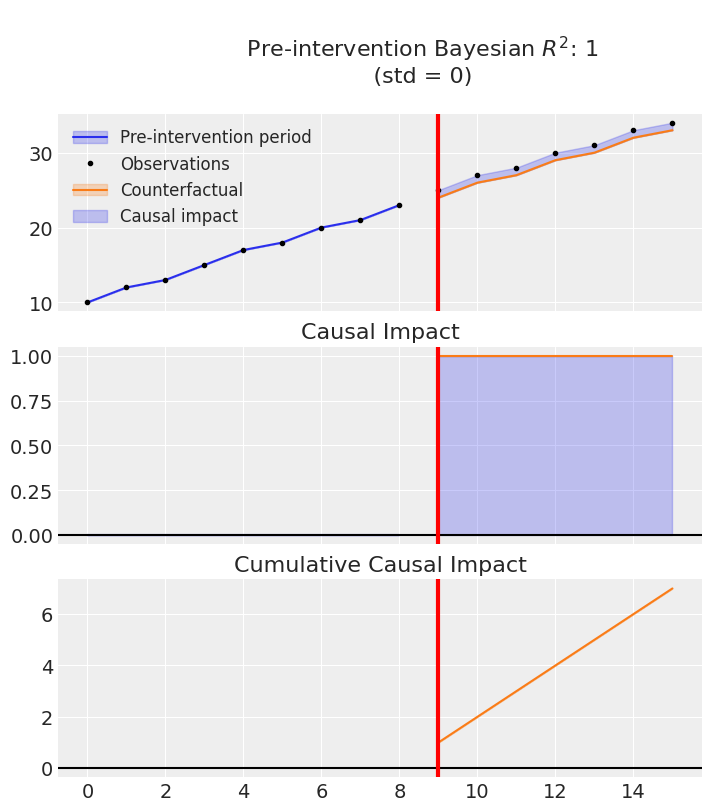

In [8]:
# Fórmula do modelo para o controle sintético
# A coluna tratada é identificada como `serie_t` e as doadoras selecionadas estão no `selected_donors`
formula = treated_col + " ~ 0 + " + " + ".join(selected_donors)

# Ajustar o controle sintético bayesiano com as séries selecionadas
result = cp.SyntheticControl(
    df_selected, # DataFrame contendo as séries tratada e doadoras
    treatment_time, # Índice do início do tratamento
    formula=formula, # Fórmula que inclui a série tratada e as doadoras
    model=cp.pymc_models.WeightedSumFitter( # Ajuste bayesiano para estimar os pesos     

        sample_kwargs = {
            "draws": 500,         # nº de amostras retiradas da distribuição posterior após o período de ajuste (warm-up)
            "tune": 500,          # Passos de ajuste do sampler (warm-up) antes de coletar amostras. Amostras não são incluídas na distribuição posterior.
            "chains": 4,           # Número de cadeias independentes de MCMC que serão executadas
            "cores": 2,            # Número de núcleos de processamento para paralelizar as cadeias
            "random_seed": 42,     # Semente para garantir reprodutibilidade
            "target_accept": 0.8,  # Taxa de aceitação alvo para o sampler NUTS
            "progressbar": True,   # Exibir barra de progresso durante a amostragem
            "return_inferencedata": True, # Retorna o resultado no formato arviz.InferenceData (recomendado para vis e análise).
            "init": "auto",        # Estratégia para inicializar valores iniciais (e.g., "auto", "adapt_diag")
            "discard_tuned_samples": True, # Descartar amostras ajustadas (warm-up ou tune) no resultado final.
            "method": "NUTS",      # Método de amostragem a ser usado (e.g., "NUTS", "Metropolis")
                                   # "NUTS": Sampler de Hamiltoniano (padrão e eficiente para modelos contínuos).
                                   # "Metropolis": Amostrador de Metropolis-Hastings (mais lento, mas pode ser útil para distribuições complexas).


            "step": None,          # Objeto específico de passo de amostragem (substitui o padrão)
            "compute_convergence_checks": True, # Realiza verificações automaticas de convergência (e.g., R-hat)
            "jitter_max_retries": 10, # Tentativas para inicializar com jitter em caso de erro numérico
        }

    ),
)


# Visualizar os resultados do controle sintético
result.plot()  # Plota o contrafactual estimado e o impacto do tratamento



In [9]:
result.summary()

==================================Pre-Post Fit==================================
Formula: serie_t ~ 0 + c + d
Model coefficients:
    c      1, 94% HDI [1, 1]
    d      3.6e-17, 94% HDI [1.5e-18, 1.1e-16]
    sigma  1.8e-162, 94% HDI [1.6e-162, 2.4e-162]


In [12]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,1.0,0.0,1.0,1.0,0.0,0.0,51.0,126.0,1.07


In [13]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,7.0,0.0,7.0,7.0,0.0,0.0,51.0,126.0,1.07
